# **Step 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# **Step 2: Load Dataset and Check Info.**

In [2]:
df = pd.read_csv("/kaggle/input/mushroom-classification/mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
df.shape

(8124, 23)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [5]:
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

# **Step 3: Exploratory Data Analysis (EDA)**

## **Target Distribution**

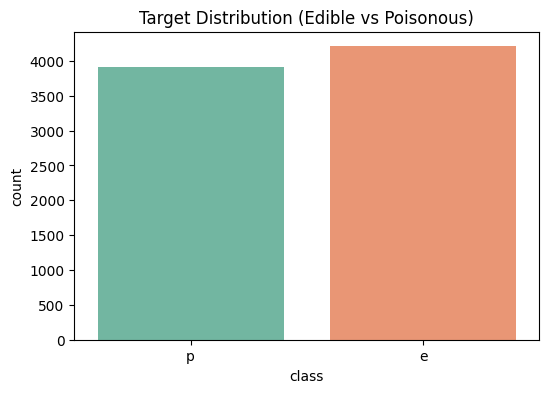

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="class", palette="Set2")
plt.title("Target Distribution (Edible vs Poisonous)")
plt.show()

## **Visualize Categorical Features (first 6 columns)**

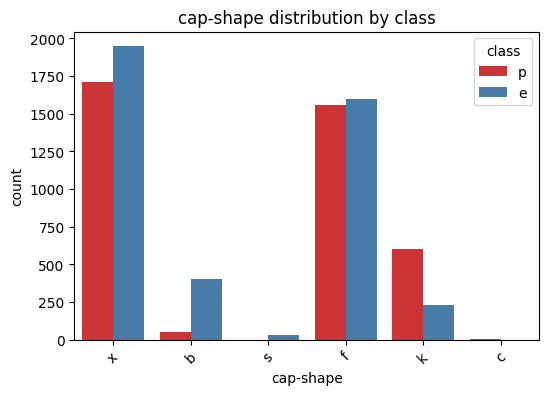

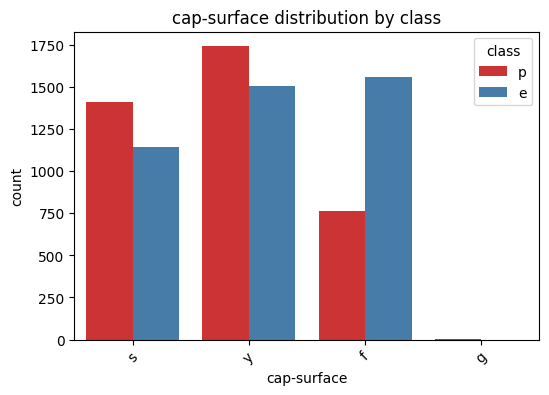

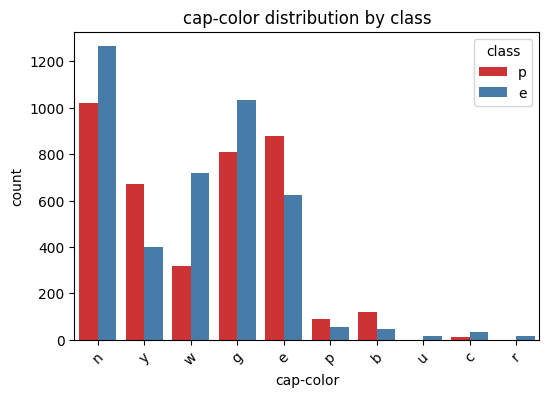

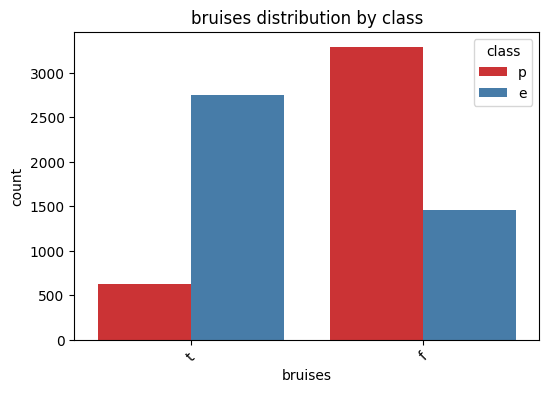

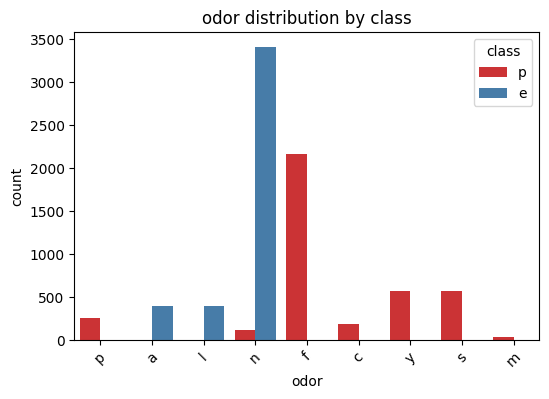

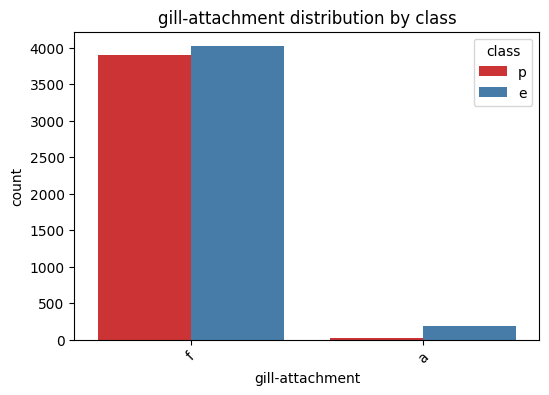

In [7]:
categorical_cols = df.columns[1:7]
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue="class", palette="Set1")
    plt.title(f"{col} distribution by class")
    plt.xticks(rotation=45)
    plt.show()

## **Correlation with target (one-hot + Pearson)**

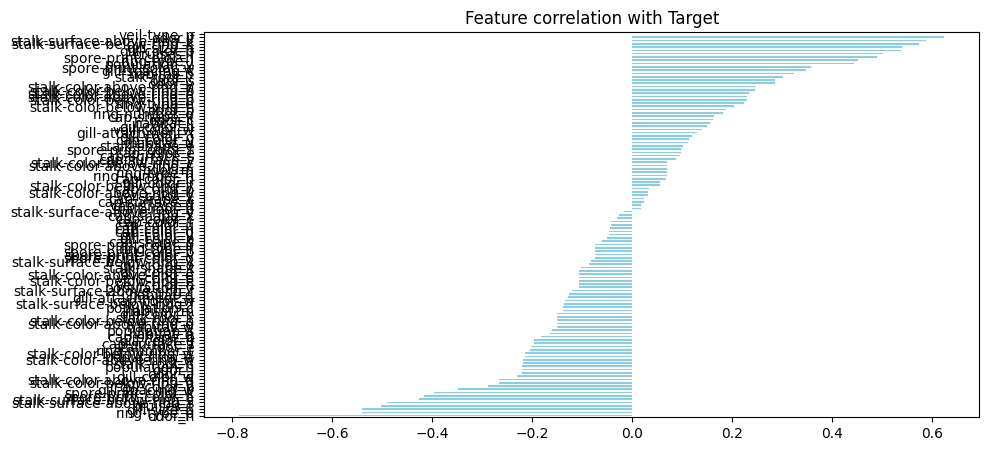

In [8]:
encoded = pd.get_dummies(df.drop("class", axis=1))
corr = encoded.corrwith(pd.Series(np.where(df["class"]=="p",1,0)))
plt.figure(figsize=(10,5))
corr.sort_values().plot(kind="barh", color="skyblue")
plt.title("Feature correlation with Target")
plt.show()

## **Key Features Visualization**

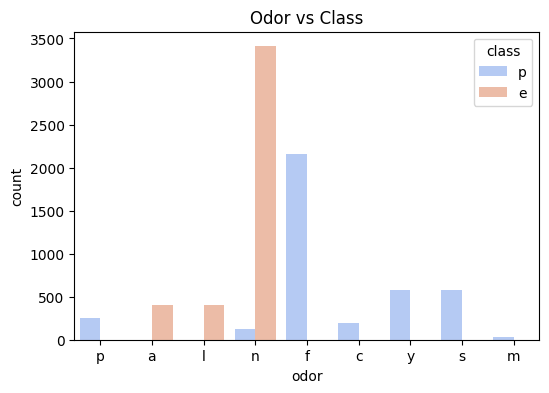

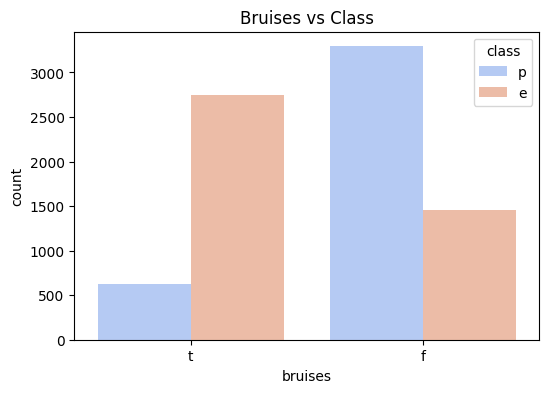

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['odor'], hue=df['class'], palette="coolwarm")
plt.title("Odor vs Class")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=df['bruises'], hue=df['class'], palette="coolwarm")
plt.title("Bruises vs Class")
plt.show()

# **Step 4: Data Cleaning and Feature Engineering**

In [10]:
df_clean = df.replace("?", np.nan)
df_clean = df_clean.fillna(df_clean.mode().iloc[0])

In [11]:
df_clean["has_odor"] = df_clean["odor"].apply(lambda x: 0 if x=="n" else 1)
df_clean["is_bruised"] = df_clean["bruises"].apply(lambda x: 1 if x=="t" else 0)
df_clean["odor_x_gillsize"] = df_clean["odor"] + "_" + df_clean["gill-size"]

In [12]:
df_clean.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,has_odor,is_bruised,odor_x_gillsize
0,p,x,s,n,t,p,f,c,n,k,...,p,w,o,p,k,s,u,1,1,p_n
1,e,x,s,y,t,a,f,c,b,k,...,p,w,o,p,n,n,g,1,1,a_b
2,e,b,s,w,t,l,f,c,b,n,...,p,w,o,p,n,n,m,1,1,l_b
3,p,x,y,w,t,p,f,c,n,n,...,p,w,o,p,k,s,u,1,1,p_n
4,e,x,s,g,f,n,f,w,b,k,...,p,w,o,e,n,a,g,0,0,n_b


# **Step 5: Train-Test Split and Preprocessor**

In [13]:
X = df_clean.drop("class", axis=1)
y = df_clean["class"].map({"e":0, "p":1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numeric_cols = X.select_dtypes(exclude="object").columns.tolist()
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# **Step 6: Define Models**

In [15]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

pipelines = {name: Pipeline([("preprocess", preprocess), ("model", clf)]) for name, clf in models.items()}


# **Step 7: Evaluation Function**

In [16]:
def evaluate_model(name, pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "fpr": fpr,
        "tpr": tpr,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "pipeline": pipeline
    }

# **Step 8: Train and Evaluate Untuned Models**

In [17]:
results = []
for name, pipe in pipelines.items():
    res = evaluate_model(name, pipe, X_train, X_test, y_train, y_test)
    results.append(res)

accuracy_df = pd.DataFrame({
    "Model": [r["model"] for r in results],
    "Accuracy": [r["accuracy"] for r in results]
})

accuracy_df = accuracy_df.sort_values(by="Accuracy", ascending=False)
print("\nUntuned Models Accuracy:")
print(accuracy_df)

best_model_name = accuracy_df.iloc[0]["Model"]
best_model_acc = accuracy_df.iloc[0]["Accuracy"]
print(f"\nBest Untuned Model: {best_model_name} with Accuracy: {best_model_acc:.4f}")



Untuned Models Accuracy:
                 Model  Accuracy
1                  KNN  1.000000
2        Decision Tree  1.000000
3        Random Forest  1.000000
4                  SVM  1.000000
6    Gradient Boosting  1.000000
7             AdaBoost  1.000000
8              XGBoost  1.000000
0  Logistic Regression  0.999385
5          Naive Bayes  0.996923

Best Untuned Model: KNN with Accuracy: 1.0000


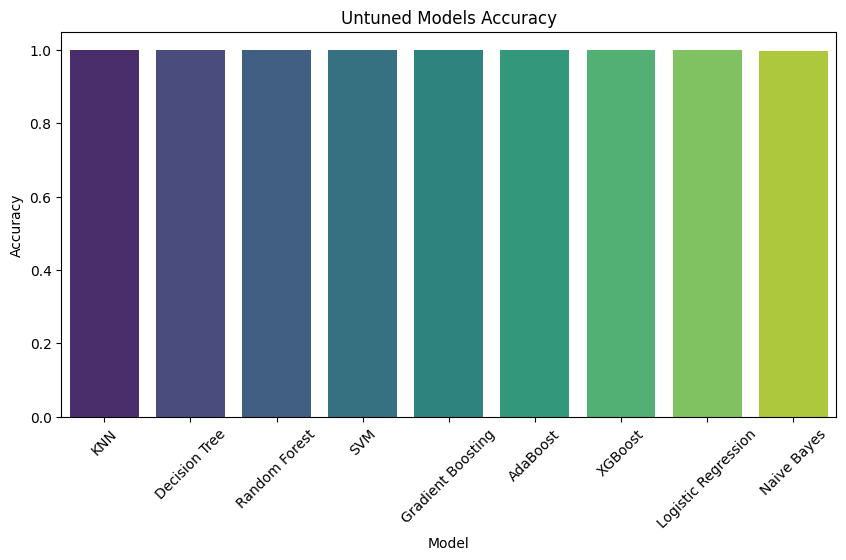

In [18]:
plt.figure(figsize=(10,5))
sns.barplot(data=accuracy_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Untuned Models Accuracy")
plt.xticks(rotation=45)
plt.show()

## **ROC Curves for Untuned Models**

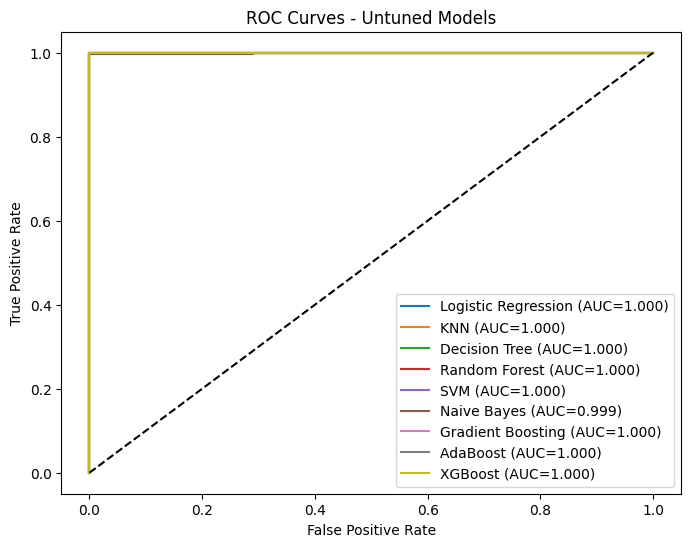

In [19]:
plt.figure(figsize=(8,6))
for r in results:
    plt.plot(r["fpr"], r["tpr"], label=f"{r['model']} (AUC={r['roc_auc']:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curves - Untuned Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## **Confusion Matrix & Report for best Untuned Model**


Best Untuned Model: KNN


<Figure size 600x500 with 0 Axes>

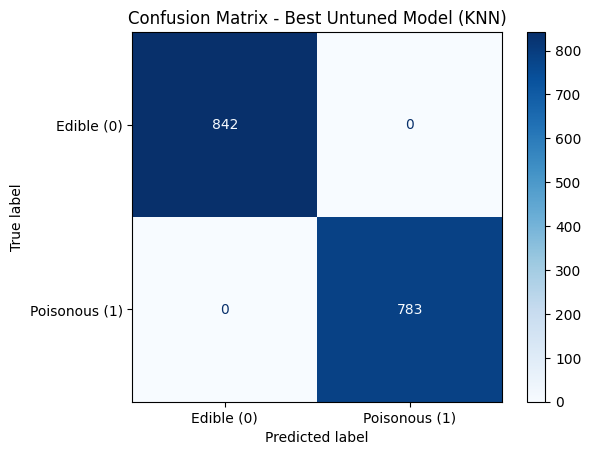

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [20]:
best_untuned = max(results, key=lambda x: x["accuracy"])

print(f"\nBest Untuned Model: {best_untuned['model']}")
cm = confusion_matrix(y_test, best_untuned["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Edible (0)", "Poisonous (1)"])
plt.figure(figsize=(6,5))
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - Best Untuned Model ({best_untuned['model']})")
plt.show()

print("Classification Report:\n", classification_report(y_test, best_untuned["y_pred"]))

# **Step 9: Hyperparameter Tuning (GridSearchCV)**

In [21]:
param_grids = {
    "Logistic Regression": {"model__C":[0.1,1,10]},
    "KNN": {"model__n_neighbors":[3,5,7]},
    "Decision Tree": {"model__max_depth":[None,5,10]},
    "Random Forest": {"model__n_estimators":[50,100], "model__max_depth":[None,10]},
    "SVM": {"model__C":[0.1,1], "model__kernel":["linear","rbf"]},
    "Naive Bayes": {},  # no params
    "Gradient Boosting": {"model__n_estimators":[50,100], "model__learning_rate":[0.05,0.1]},
    "AdaBoost": {"model__n_estimators":[50,100], "model__learning_rate":[0.05,0.1]},
    "XGBoost": {"model__n_estimators":[50,100], "model__max_depth":[3,5]},
    "LightGBM": {"model__n_estimators":[50,100], "model__num_leaves":[31,50]}
}

## **Train & Evaluate for Tuned Models**

In [22]:
tuned_results = []
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe, param_grids[name], scoring="roc_auc", cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:,1]

    tuned_results.append({
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "fpr": roc_curve(y_test,y_proba)[0],
        "tpr": roc_curve(y_test,y_proba)[1],
        "best_estimator": grid.best_estimator_
    })

In [23]:
tuned_df = pd.DataFrame({
    "Model": [r["model"] for r in tuned_results],
    "Accuracy": [r["accuracy"] for r in tuned_results]
})

tuned_df = tuned_df.sort_values(by="Accuracy", ascending=False)
print("\nTuned Models Accuracy:")
print(tuned_df)

best_tuned_model_name = tuned_df.iloc[0]["Model"]
best_tuned_model_acc = tuned_df.iloc[0]["Accuracy"]
print(f"\nBest Tuned Model: {best_tuned_model_name} with Accuracy: {best_tuned_model_acc:.4f}")



Tuned Models Accuracy:
                 Model  Accuracy
1                  KNN  1.000000
2        Decision Tree  1.000000
3        Random Forest  1.000000
8              XGBoost  1.000000
0  Logistic Regression  0.999385
6    Gradient Boosting  0.998769
7             AdaBoost  0.998154
5          Naive Bayes  0.996923
4                  SVM  0.996308

Best Tuned Model: KNN with Accuracy: 1.0000


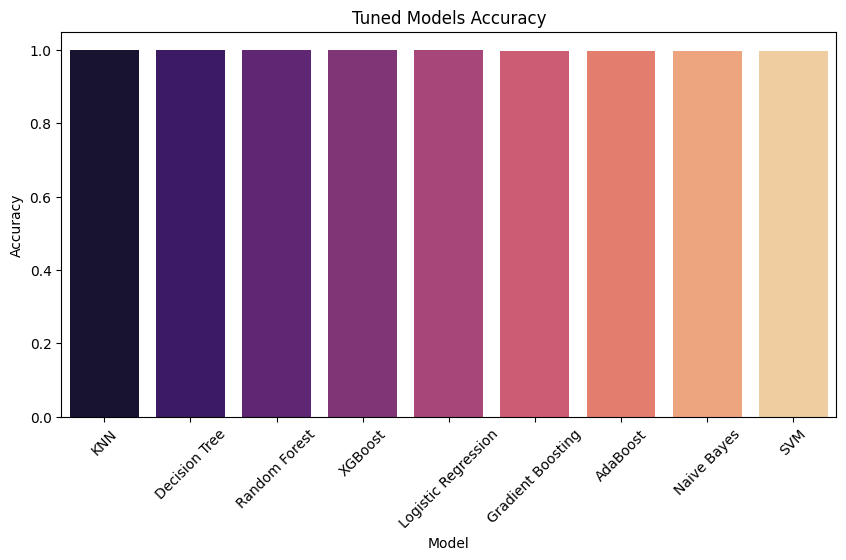

In [24]:
plt.figure(figsize=(10,5))
sns.barplot(data=tuned_df, x="Model", y="Accuracy", palette="magma")
plt.title("Tuned Models Accuracy")
plt.xticks(rotation=45)
plt.show()

**ROC Curves for Tuned Models**

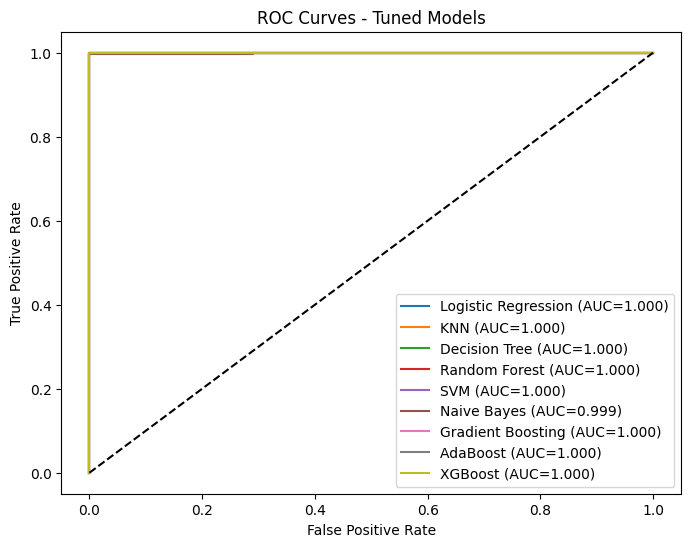

In [25]:
plt.figure(figsize=(8,6))
for r in tuned_results:
    plt.plot(r["fpr"], r["tpr"], label=f"{r['model']} (AUC={r['roc_auc']:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curves - Tuned Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## **Confusion Matrix & Report for best Tuned Model**


Best Tuned Model: KNN


<Figure size 600x500 with 0 Axes>

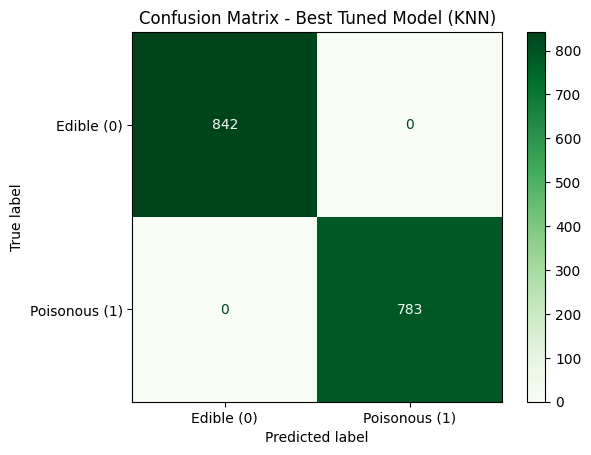

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [26]:
best_tuned = max(tuned_results, key=lambda x: x["accuracy"])

print(f"\nBest Tuned Model: {best_tuned['model']}")
cm_tuned = confusion_matrix(y_test, best_tuned["y_pred"])
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=["Edible (0)", "Poisonous (1)"])

plt.figure(figsize=(6,5))
disp_tuned.plot(cmap="Greens", values_format="d")
plt.title(f"Confusion Matrix - Best Tuned Model ({best_tuned['model']})")
plt.show()

print("Classification Report:\n", classification_report(y_test, best_tuned["y_pred"]))

# **Step 10: Compare Accuracies**


Comparison of Untuned vs Tuned Models (Accuracy):
                 Model  Accuracy_Untuned  Accuracy_Tuned
0                  KNN          1.000000        1.000000
1        Decision Tree          1.000000        1.000000
2        Random Forest          1.000000        1.000000
3                  SVM          1.000000        0.996308
4    Gradient Boosting          1.000000        0.998769
5             AdaBoost          1.000000        0.998154
6              XGBoost          1.000000        1.000000
7  Logistic Regression          0.999385        0.999385
8          Naive Bayes          0.996923        0.996923




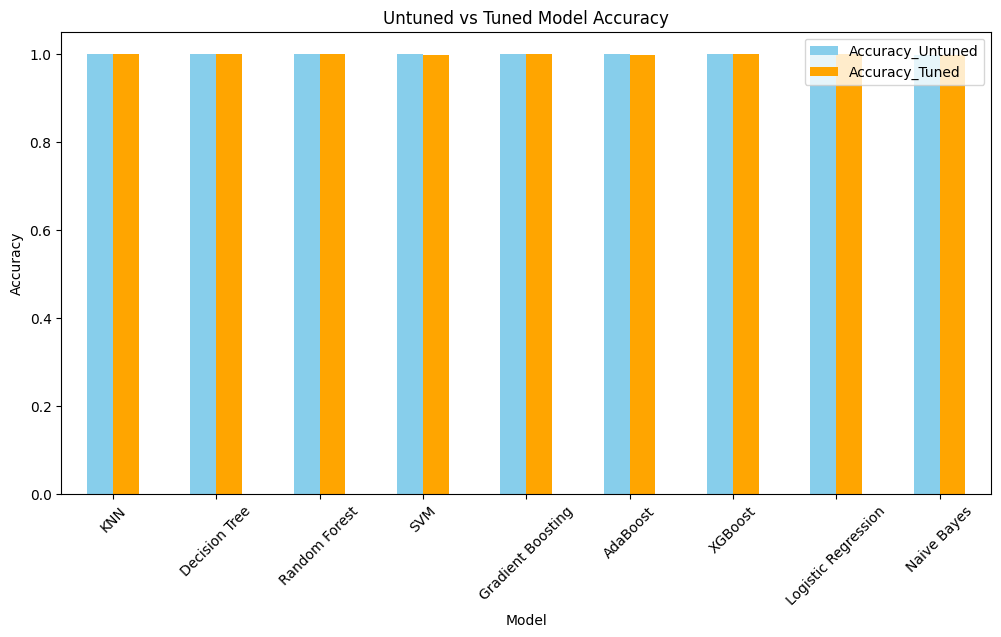

In [27]:
untuned_df = accuracy_df.rename(columns={"Model": "Model", "Accuracy": "Accuracy_Untuned"})
tuned_df   = tuned_df.rename(columns={"Model": "Model", "Accuracy": "Accuracy_Tuned"})
compare_df = pd.merge(untuned_df, tuned_df, on="Model")

print("\nComparison of Untuned vs Tuned Models (Accuracy):")
print(compare_df[["Model", "Accuracy_Untuned", "Accuracy_Tuned"]])
compare_df.set_index("Model")[["Accuracy_Untuned", "Accuracy_Tuned"]].plot(
    kind="bar", figsize=(12,6), color=["skyblue","orange"]
)
print("\n")
plt.title("Untuned vs Tuned Model Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

# **Step 11: Actual vs Predicted for Best Models**

In [28]:
actual_vs_pred = pd.DataFrame({
    "Actual": y_test,
    f"Pred_{best_untuned['model']}_untuned": best_untuned["y_pred"],
    f"Pred_{best_tuned['model']}_tuned": best_tuned["y_pred"]
})
print("\nPrediction Comparison:")
actual_vs_pred.head(10)


Prediction Comparison:


,Actual,Pred_KNN_untuned,Pred_KNN_tuned
4632,1,1,1
3444,1,1,1
1209,0,0,0
6880,1,1,1
4542,1,1,1
244,0,0,0
458,0,0,0
1315,0,0,0
980,0,0,0
2241,1,1,1


**0 : edible & 1 : poisonous**